# TextCNN

参数配置，训练数据生成，模型结构，训练模型。

In [1]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 

In [2]:
class TrainingConfig():
    epochs = 5
    batch_size= 128
    learningRate=0.001
    valRate=0.1
    loss=['sparse_categorical_crossentropy']
    metrics=['accuracy']
    optimizer='adam'
    
class WordEmbedding():
    sequenceLength=256
    wordCount=10000
    wordDim=10

class DataSourceConfig():
    source=["./dataset/imdb_train_data.npy",
           "./dataset/imdb_test_data.npy",
           "./dataset/imdb_train_labels.npy",
           "./dataset/imdb_test_labels.npy"]

In [59]:
class TextCNN():
    def __init__(self,config,wordEmbedding):
        
        self.model = None
        self.history = None
        self.config=config
        self.emb=wordEmbedding
        self.name="TextCNN"
        
    def conv1D_with_bn_gp(self,filters,kernel_size):
        blk = K.models.Sequential()
        blk.add(L.Conv1D(filters=filters,kernel_size=kernel_size))
        blk.add(L.BatchNormalization())
        blk.add(L.Activation("relu"))
        blk.add(L.GlobalMaxPool1D())
        return blk
    
    def design_model(self,hiden_size=64):
        input_layer=L.Input(shape=(None,),name='feature_input')
        x=L.Embedding(input_dim=self.emb.wordCount,output_dim=self.emb.wordDim,input_length=self.emb.sequenceLength)(input_layer)
        
        x=L.Conv1D(filters=100,kernel_size=5)(x)
        x=L.BatchNormalization()(x)
        x=L.Activation("relu")(x)
        x=L.GlobalMaxPool1D()(x)
        
        x=L.Dense(hiden_size,activation='relu',name="feature_output")(x)
        output_layer=L.Dense(2,activation='softmax')(x)
        model=K.models.Model(inputs=[input_layer],outputs=[output_layer],name=self.name)
        self.model=model
        model.summary()
        return model
    
    
    def design_model_with_multi_kernel_size(self,hiden_size=64):
        input_layer=L.Input(shape=(None,),name='feature_input')
        x=L.Embedding(input_dim=self.emb.wordCount,output_dim=self.emb.wordDim,input_length=self.emb.sequenceLength)(input_layer)
        
        
        x_5=self.conv1D_with_bn_gp(filters=100,kernel_size=5)(x)
        x_4=self.conv1D_with_bn_gp(filters=100,kernel_size=4)(x)
        x_3=self.conv1D_with_bn_gp(filters=100,kernel_size=3)(x)
        
        x=L.concatenate([x_3,x_4,x_5])
        x=L.Dense(hiden_size,activation='relu',name="feature_output")(x)
        x=L.Dropout(0.5)(x)
        output_layer=L.Dense(2,activation='softmax')(x)
        
        model=K.models.Model(inputs=[input_layer],outputs=[output_layer],name=self.name)
        self.model=model
        model.summary()
        return model
    
    def compile_model(self):
        #assert()
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.model.compile(optimizer=self.config.optimizer,loss=self.config.loss,metrics=self.config.metrics)

    def train_model(self,x,y):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
            return
        self.compile_model()
        self.history=self.model.fit(x=x,y=y,batch_size=self.config.batch_size,epochs=self.config.epochs,validation_split=self.config.valRate)
        #self.model.compile()
    def train_model_custom(self,x,y):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.1)
        print(x_train.shape)
        print(x_val.shape)
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(self.config.batch_size)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(self.config.batch_size)

        #loss
        loss_fn=K.losses.get(self.config.loss[0])
        #opt
        optimizer=K.optimizers.Adam()
        #metric
        train_acc_metric=K.metrics.SparseCategoricalAccuracy()#self.config.metrics[0])
        val_acc_metric  =K.metrics.SparseCategoricalAccuracy()#self.config.metrics[0])
        
        for times in range(self.config.epochs):
            step=0
            # 训练过程
            for x_batch_train, y_batch_train in train_dataset:
                with tf.GradientTape() as tp:
                    logits=self.model(x_batch_train)
                    loss=loss_fn(y_batch_train,logits)
                grads=tp.gradient(loss,self.model.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                train_acc_metric.update_state(y_batch_train,logits)
                
                if step % 50 == 0:
                    print('\r','Training loss (for one batch) at step %s: %s' % (step, float(tf.reduce_mean(loss))),end="",flush=True)
                    #print('Seen so far: %s samples' % ((step + 1) * self.config.batch_size))
                step+=1
            print()
            # 每个周期结束看一次
            train_acc = train_acc_metric.result()
            print('Training     acc over epoch %s: %s' % (times,float(train_acc)))
            # Reset training metrics at the end of each epoch
            train_acc_metric.reset_states()
            
            #验证过程
            for x_batch_val, y_batch_val in val_dataset:
                val_logits=self.model(x_batch_val)
                val_acc_metric.update_state(y_batch_val,val_logits)
            
            val_acc=val_acc_metric.result()
            print('Training val_acc over epoch %s: %s '%(times,float(val_acc)))
            val_acc_metric.reset_states()

            
    def save_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def eval_model(self):
        if not self.model:
            print("Call design_modelXX() to build the model first.")
        pass
    
    def view_train(self):
        if not self.history:
            print("Model has not been trained, train it first")
            return
        
        train=self.history.history["loss"]
        valid=self.history.history["val_loss"]
        name='loss'
        plt.title('The %s with epoch runs'%name,fontsize=30)
        plt.xlabel('epoch',fontsize=20)
        plt.ylabel(name,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(train,label=name)
        plt.plot(valid,label="val_"+name)
        plt.legend()
        plt.gcf().set_size_inches(15,4)
        plt.show()
    #model=K.models.Model(inputs=[input_layer],outputs=[output_layer])
    #model.compile('adam',loss='categorical_crossentropy',metrics=metrics)
    #return model

In [65]:
train_config=TrainingConfig()
word_embedding=WordEmbedding()
model=TextCNN(train_config,word_embedding)

In [66]:
model.design_model()

Model: "TextCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding_9 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 100)         5100      
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 100)         400       
_________________________________________________________________
activation_9 (Activation)    (None, None, 100)         0         
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
feature_output (Dense)       (None, 64)                6464

In [67]:
class Dataset():
    def __init__(self,config):
        self.config=config
    def load(self):
        L=[]
        for item in self.config.source:
            L.append(np.load(item,allow_pickle=True, fix_imports=True))
        return L

In [68]:
data=Dataset(DataSourceConfig)
train_data,test_data,train_labels,test_labels=data.load()

In [69]:
#费力讨好
model.train_model_custom(x=train_data,y=train_labels)

(22500, 256)
(2500, 256)
 Training loss (for one batch) at step 150: 0.4542102813720703
Training     acc over epoch 0: 0.6574222445487976
Training val_acc over epoch 0: 0.8299999833106995 
 Training loss (for one batch) at step 150: 0.2171655297279358
Training     acc over epoch 1: 0.8717333078384399
Training val_acc over epoch 1: 0.8859999775886536 
 Training loss (for one batch) at step 150: 0.1336461305618286
Training     acc over epoch 2: 0.9272000193595886
Training val_acc over epoch 2: 0.8859999775886536 
 Training loss (for one batch) at step 150: 0.09564494341611862
Training     acc over epoch 3: 0.9576444625854492
Training val_acc over epoch 3: 0.876800000667572 
 Training loss (for one batch) at step 150: 0.033552203327417374
Training     acc over epoch 4: 0.9705777764320374
Training val_acc over epoch 4: 0.8392000198364258 


In [41]:
model.train_model(x=train_data,y=train_labels)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 3s 137us/sample - loss: 0.6849 - accuracy: 0.5507 - val_loss: 0.6776 - val_accuracy: 0.6936
Epoch 2/5
22500/22500 [==============================] - 2s 103us/sample - loss: 0.4330 - accuracy: 0.8097 - val_loss: 0.5410 - val_accuracy: 0.8744
Epoch 3/5
22500/22500 [==============================] - 2s 99us/sample - loss: 0.2872 - accuracy: 0.8900 - val_loss: 0.3504 - val_accuracy: 0.8872
Epoch 4/5
22500/22500 [==============================] - 2s 94us/sample - loss: 0.2101 - accuracy: 0.9265 - val_loss: 0.2871 - val_accuracy: 0.8856
Epoch 5/5
22500/22500 [==============================] - 2s 106us/sample - loss: 0.1438 - accuracy: 0.9536 - val_loss: 0.3405 - val_accuracy: 0.8868


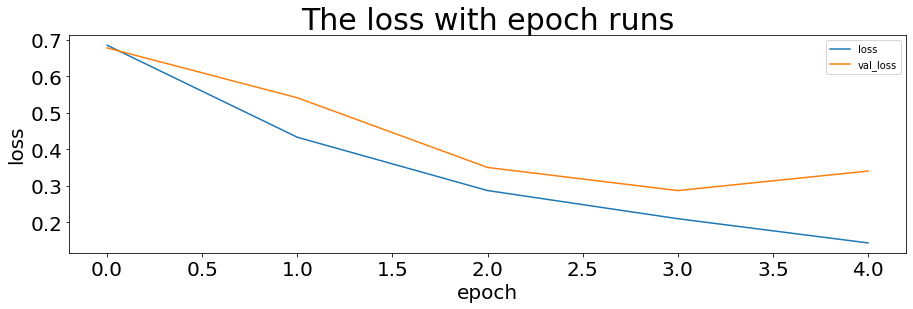

In [43]:
model.view_train()